In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import itertools

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
def correctTimestamp(timestamp):
    '''
    Correct missing timezone information to US/Pacific from UTC
    
    Parameters
    ----------
    timestamp : str, pandas.Timestamp
        The naive timestamp to correct
        
    Return
    ----------
    A corrected, US/Pacific aware timestamp
    '''
    if type(timestamp) is str:
        timestamp = Timestamp(datetime.strptime(timestamp, '%x %H:%M').replace(tzinfo=timezone('UTC')))
    if timestamp.tzinfo is None:
        timestamp = timestamp.tz_localize('UTC')
        
    return timestamp.tz_convert('US/Pacific')

In [3]:
full_history = pd.read_json('data/history_comp.json')
full_history['timestamp'] = full_history['timestamp'].apply(correctTimestamp)
full_history = full_history.drop('index', axis=1)

In [ ]:
full_history = full_history.sample(5000)

As shown below, for every 19 songs listened to, 10 of them are unique to my music catalog.

In [4]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

1.8613094024066899

In [5]:
artists = pd.read_json('data/artist_info.json')
artists.sample(5)

,artist,followers,genres,id,popularity
1843,Method Man,471493,"[dirty south rap, east coast hip hop, gangster...",4VmEWwd8y9MCLwexFMdpwt,68
1243,Tali,11524,"[reggaeton flow, trap latino]",52izvDWTdRIQPsrI0IaHNx,55
3027,Khruangbin,93256,"[funk, indie jazz]",2mVVjNmdjXZZDvhgQWiakk,65
1457,John Lennon,1431470,"[album rock, art rock, classic rock, folk chri...",4x1nvY2FN8jxqAFA0DA02H,69
2926,Destroyer,70489,"[alternative dance, alternative rock, art pop,...",22ojy4H4ZVpowC4lRRC8In,54


count    9126.000000
mean        0.308442
std         0.314812
min         0.000003
25%         0.044300
50%         0.183000
75%         0.515000
max         0.996000
Name: acousticness, dtype: float64

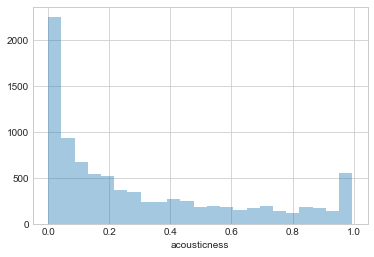

In [6]:
sns.distplot(full_history['acousticness'], kde=False)
full_history['acousticness'].describe()

count    9126.000000
mean        0.602877
std         0.168923
min         0.063400
25%         0.492000
50%         0.614000
75%         0.730000
max         0.984000
Name: danceability, dtype: float64

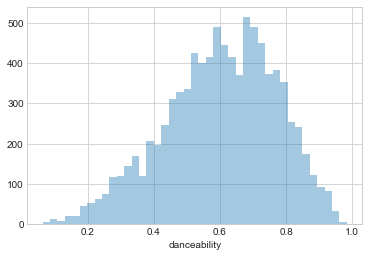

In [7]:
sns.distplot(full_history['danceability'], kde=False)
full_history['danceability'].describe()

count    9126.000000
mean        1.304663
std         0.304398
min        -0.568366
25%         1.153562
50%         1.299283
75%         1.463768
max         3.715397
Name: log_duration, dtype: float64


0.0584329634870428

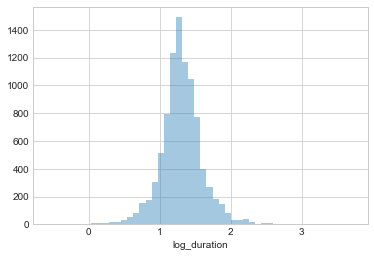

In [8]:
full_history['log_duration'] = np.log(full_history['duration_ms'] / 1000 / 60)
sns.distplot(full_history['log_duration'], kde=False)
print(full_history['log_duration'].describe())
stats.skew(full_history['log_duration'])

In [9]:
full_history = full_history.drop('duration_ms', axis=1)

count    9126.000000
mean        0.567615
std         0.226944
min         0.000803
25%         0.431000
50%         0.586000
75%         0.733000
max         0.998000
Name: energy, dtype: float64

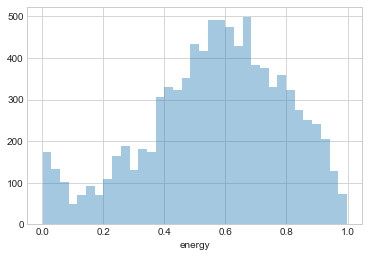

In [10]:
sns.distplot(full_history['energy'], kde=False)
full_history['energy'].describe()

count    9126.000000
mean        0.187905
std         0.154291
min         0.018700
25%         0.097600
50%         0.123000
75%         0.226000
max         0.989000
Name: liveness, dtype: float64

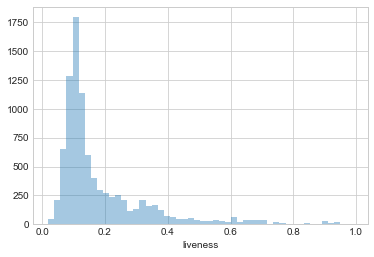

In [11]:
sns.distplot(full_history['liveness'], kde=False)
full_history['liveness'].describe()

In [12]:
full_history[full_history['liveness'] > 0.75].drop_duplicates('id')['name']

1007                                       Round Whippin'
1073                                   Ain't Love Strange
113                                       Ragged Old Flag
1180                                 Put Your Money on Me
1224                                                  RUN
1236                                         Silvertongue
1243                                            Hound Dog
125                         Escape (The Pina Colada Song)
1256                                                 TEAM
1301    Satellite / Stealing Time - Live At The Hollyw...
1425           On A Good Day - Live At The Hollywood Bowl
144                                            LD50 - VIP
1442                                                 WDYW
1467                                                Pt. 2
148              Jah No Partial - Heroes x Villains Remix
1517                                              Feel Me
1849                                            Intention
1872          

Liveness is obviously an inaccurate measurement, thus we cannot use it reliably. We remove it.

In [13]:
full_history = full_history.drop('liveness', axis=1)

count    9126.000000
mean        2.162364
std         0.458975
min        -0.529329
25%         1.880381
50%         2.124056
75%         2.374347
max         3.877990
Name: log_loudness, dtype: float64

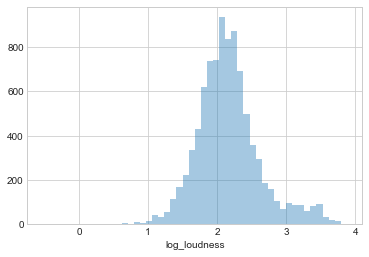

In [14]:
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
sns.distplot(full_history['log_loudness'], kde=False)
full_history['log_loudness'].describe()

In [15]:
full_history = full_history.drop('loudness', axis=1)

count    9126.000000
mean       55.498685
std        17.477593
min         0.000000
25%        46.000000
50%        57.000000
75%        67.000000
max       100.000000
Name: popularity, dtype: float64

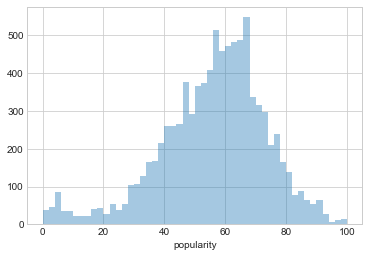

In [16]:
sns.distplot(full_history['popularity'], kde=False)
full_history['popularity'].describe()

count    9126.000000
mean      117.698115
std        29.647410
min        32.000000
25%        94.000000
50%       119.000000
75%       140.000000
max       222.000000
Name: tempo, dtype: float64

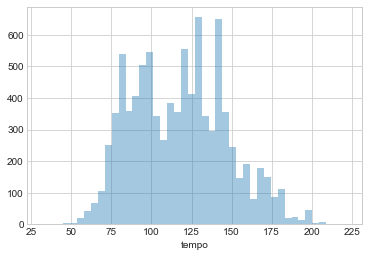

In [17]:
full_history['tempo'] = full_history['tempo'].apply(round)
sns.distplot(full_history['tempo'], kde=False)
full_history['tempo'].describe()

Many songs are misclassified by Spotify, often doubling the real BPM. Presto tempo is said to be above 168, and after looking through many of the resutls of songs above 168 BPM, it is reasonable to correct songs above this threshold. Although it does cut out the top end, it is more representative for ~200 songs.

In [18]:
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)

count    9126.000000
mean        0.424578
std         0.235932
min         0.029800
25%         0.233000
50%         0.399500
75%         0.596000
max         0.990000
Name: valence, dtype: float64

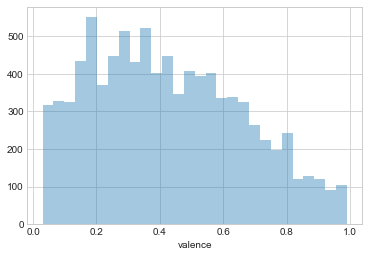

In [19]:
sns.distplot(full_history['valence'], kde=False)
full_history['valence'].describe()

The release date isn't accurate either. For example, all classical music has release dates of 1960 or later, since this is the release of the album itself, not necessarily the conception of the music (which would have placed a lot of this genre in the 17th-20th centuries).

In [20]:
full_history = full_history.drop('release', axis=1)

In [21]:
full_history.sample(5)

,acousticness,album,artists,danceability,energy,explicit,id,key,mode,name,popularity,speechiness,tempo,time_signature,timestamp,valence,log_duration,log_loudness
2588,0.00244,Symphony Soldier,[2C2sVVXanbOpymYBMpsi89],0.458,0.917,0,6Po2A4lsnVu0GrQ8Dy1nme,5,0,Temporary Bliss,58,0.1040,154.0,4,2018-02-28 13:27:00-08:00,0.6890,1.318314,1.687509
1847,0.02010,Lost & Found EP,[0e7jcv95x5MTycydtfg6wv],0.692,0.695,0,2we1ouAzi78tmtDJ72dX85,9,1,Without You,52,0.0354,120.0,4,2018-03-09 17:33:00-08:00,0.6160,1.098612,1.775969
8416,0.12000,Biz's Baddest Beats: The Best Of Biz Markie,[22282KfMxDo2PMjnBc82I4],0.862,0.663,0,3yNVfRQlUPViUh8O2V9SQn,0,1,Just A Friend,65,0.2100,85.0,4,2017-12-23 18:16:00-08:00,0.8370,1.379047,2.302985
6867,0.00583,I Am...,"[20qISvAhX20dpIbOOzGK3q, 59wfkuBoNyhDMQGCljbUbA]",0.678,0.770,1,158DIbrVt4YbqNnWyRCS3P,9,0,Hate Me Now,69,0.2220,90.0,4,2018-04-16 10:19:00-07:00,0.4120,1.554630,1.686214
2185,0.01140,Nostalgia,[7cYEt1pqMgXJdq00hAwVpT],0.422,0.609,0,2jQiSYrwJehQAcuaaQrXnS,11,0,Friends,67,0.0335,107.0,3,2018-03-03 16:54:00-08:00,0.0911,1.343783,1.996196


## What kinds of music do I listen to?

First, what types of genres?

In [22]:
def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
        
        # if there is any artist data for that artist
        if (artists['id'] == track_artist).any():
            
            # collect genres from artists that match the current one
            for genre in artists[artists['id'] == track_artist]['genres']:
                inner_gs.append(genre)
                
    u = np.unique(list(itertools.chain(*inner_gs)))
    
    if len(u) > 0:
        row['genres'] = u
    else:
        row['genres'] = None
        
    return row


In [23]:
full_history = full_history.apply(addTrackGenres, 1)

In [24]:
collective_genres = []
for genre in full_history.loc[full_history['genres'].notnull(), 'genres']:
    collective_genres.append(genre)
    
collective_genres = np.array(list(itertools.chain(*collective_genres)))
unique_genres, genre_counts = np.unique(collective_genres, return_counts=True)
genre_df = pd.DataFrame({'genre': unique_genres, 'freq': genre_counts/genre_counts.sum()})

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


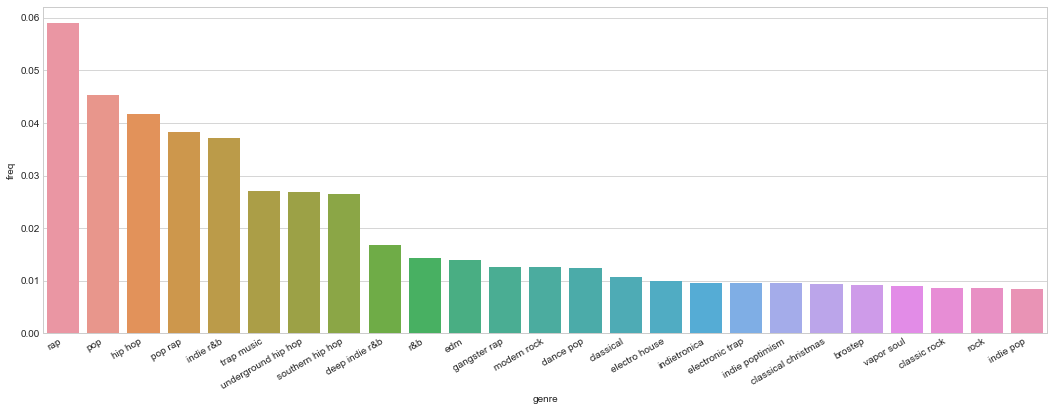

In [25]:
offset = 0
sort_genre_df = genre_df.sort_values('freq', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='genre', y='freq', data=sort_genre_df[offset:offset+25])
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');

What is the mood like?

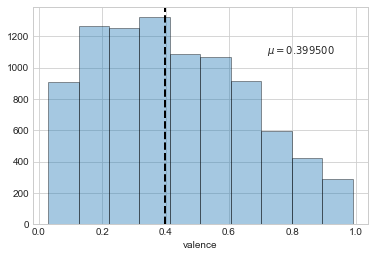

In [26]:
ax = sns.distplot(full_history.valence, bins=10, kde=False, hist_kws={"edgecolor": "k", "linewidth":1})
plt.axvline(full_history.valence.median(), color='k', linestyle='--', linewidth=2);
plt.text(0.8, 0.8, r'$\mu={0:2f}$'.format(full_history.valence.median()), 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes);

Most listened to artists

In [27]:
collective_artists = []
for artist in full_history.loc[full_history['artists'].notnull(), 'artists']:
    collective_artists.append(artist)
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'artist': unique_artists, 'freq': artist_counts/artist_counts.sum()})
artist_df = pd.merge(artist_df, artists, left_on='artist', right_on='id')[['artist_y', 'freq', 'genres']]

def simplifyGenre(x):
    for genre in sort_genre_df['genre']:
        if genre in x:
            return genre
        
    return 'other'

artist_df['genres'] = artist_df['genres'].apply(simplifyGenre)

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


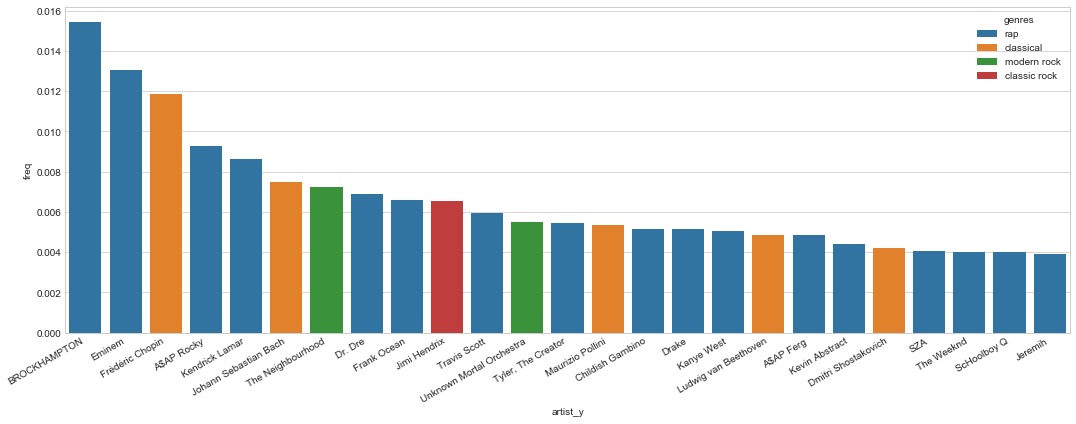

In [28]:
offset = 0
sort_artist_df = artist_df.sort_values('freq', ascending=False)[offset:offset+25]

plt.subplots(figsize=(18,6))
g = sns.barplot(x='artist_y', y='freq', data=sort_artist_df, hue='genres', dodge=False)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right');

How diverse is my music collection? Or, is my music diverse?

Suppose it's not. Then we would expect every song to homeogeneous in terms of quantitative musical qualities. Specifically, we would expect acousticness, danceability, duration, energy, volume, speechiness, tempo, and valence to be about the same for every song. 

We may assume that features of every song would be at least near the corresponding feature's mean. We may also assume that if every song is about the same, the distribution of each feature may be approximately normal.

Based on these assumptions, we can construct null hypothesis distributions for each feature, where the mean is equal to the observed mean, and the standard deviation is also equal to the observed standard deviation.

Now we possess two distributions and can compare them using the Anderson-Darling test to identify similar distributions. We suppose our null hypothesis for each feature is that both distributions are equivalent.
To reject each feature's null hypothesis, .... Let's look at the results:

In [ ]:
features = ['acousticness', 'danceability', 'duration_ms',
       'energy', 'loudness', 'speechiness', 'tempo', 'valence']
feat_means = full_history[features].mean()
feat_stds = full_history[features].std()

In [ ]:
plt.subplots(figsize=(16,16))

m = 10000

for i, f in enumerate(features):
    plt.subplot(4,3,i+1)
    
    norm = np.random.normal(feat_means[i], feat_stds[i], m)

    ax = sns.distplot(norm)
    sns.distplot(full_history[f])
    test = stats.anderson_ksamp([full_history[f], norm])
    plt.text(0.7, 0.8, r'$AD-Test={:0.3f}{}2.718$'.format(test[0],'<' if bool(test[0] < 2.718) else '>'),
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

From the above graphs, we can see that not a single feature is homogeneous enough to be considered "diverse" under our standards. Notably homogeneous features include energy, danceability, valence, and tempo.

Based on these results, my music collection is not homogeneous and thus is musically diverse.

In [ ]:
def genreFilter(history, genres):
    '''
    filter
    '''
    indices = []

    for i, r in history.iterrows():
        if type(genres) is list:
            for genre in genres:
                if r['genres'] is not None and genre in r['genres']:
                    indices.append(i)
                    break
        elif type(genres) is str:
            if genres in r['genres']:
                indices.append(i)
            
    if not indices:
        raise Exception('No tracks found for genre: {}'.format(genres))

    return history[history.index.isin(indices)]

In [ ]:
genre = ['rock']

subs = genreFilter(full_history, genre)

subs_feat_means = subs[features].mean()
subs_feat_stds = subs[features].std()

plt.subplots(figsize=(16,16))

m = len(subs)

for i, f in enumerate(features):
    plt.subplot(4,3,i+1)
    
    norm = np.random.normal(subs_feat_means[i], subs_feat_stds[i], m)

    ax = sns.distplot(norm)
    sns.distplot(subs[f])
    test = stats.anderson_ksamp([subs[f], norm])
    plt.text(0.7, 0.8, r'$AD-Test={:0.3f}{}2.718$'.format(test[0],'<' if bool(test[0] < 2.718) else '>'),
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Variability in time

## When do I listen to music?

In [ ]:
m = full_history['timestamp'].astype(np.int64) // 10**9
m = m.sort_values(ascending=False).reset_index(drop=True)
n = np.array([m[i] - m[i+1] for i in range(len(m) - 1)])

cv = n.std()/n.mean()
(cv, (cv-1)/(cv+1))

In [29]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

In [30]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

In [31]:
def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [32]:
full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [33]:
def _averageDatetimeFrequency(df, hour_inc):
    hour_bins = np.arange(0, 24, hour_inc)
    hour_labels = np.arange(hour_inc, 24, hour_inc)

    df['time_bin'] = pd.cut(df['hour_decimal'], bins=hour_bins, labels=hour_labels)
    
    history_time_bivar = df.groupby(['weekday', 'time_bin'], axis=0)
    return history_time_bivar.size().unstack().fillna(0)

def plotAverageDatetimeFrequency(data, title='', fs=(12,5), hour_inc=0.5):
    plt.subplots(figsize=fs)
    plt.title('Average Listening Date-time Frequency{}'.format(title))
    g = sns.heatmap(_averageDatetimeFrequency(data, hour_inc), cmap="Blues", robust=True)
    g.set(yticklabels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']); # use ; to suppress output

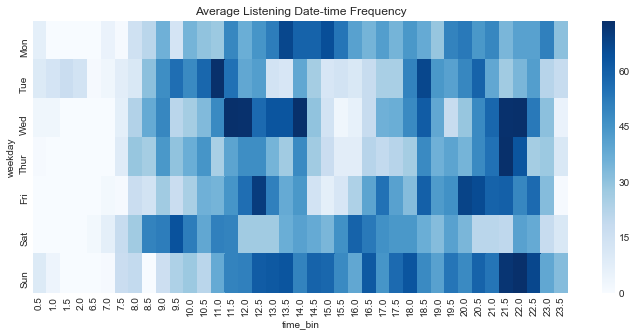

In [34]:
plotAverageDatetimeFrequency(full_history, hour_inc=0.5)

In [ ]:
a = []

inc = 1

hour_bins = np.arange(0, 24, inc)
hour_labels = np.arange(inc, 24, inc)
day_bins = np.arange(0,7)
g = None
for t_genre in sort_genre_df['genre'][0:2]:
    g = genreFilter(full_history, [t_genre])
    a.append(_averageDatetimeFrequency(g, inc))
    
b = pd.DataFrame(index=day_bins, columns=hour_bins)
b = b.fillna(0)

spot_max = np.nan

print((a[0].shape, b.shape))

for x in hour_bins:
    for y in day_bins:
        for s in range(2):
            #print((a[s].iloc[y, x]), b.iloc[y, x], s)
            #print((y, x, s))
            if a[s].shape[1]-1 < x:
                break
                
            if a[s].iloc[y, x] > b.iloc[y, x]:
                b.iloc[y, x] = s
b

## What music do I *actually* like?

With thousands of songs in my music listening history, it should be obvious that I don't *love* all of them. If we wish to describe the songs I like, the dataset must be labeled with whether I like a particular song. In other words, we extract implicit feedback to classify songs as "Like" or "Dislike." Implicit feedback is easier to collect because it does not require individually labeling each sample. Here, we define this feedback as listening frequency. It is assumed that songs that are enjoyed are listened to more often than songs that are not enjoyed.

There are two flavors of frequency feedback: absolute and relative. Absolute frequency feedback (AFF) is the listening frequency within the know period of recording. Relative frequency feedback (RFF) is the listening frequency between the first and last listening event. AFF accounts for long-term listening habits. RFF accounts for songs that were enjoyed during one period in time (and may still be enjoyed).

In [35]:
day_range = (full_history['timestamp'].max() - full_history['timestamp'].min()).days

In [36]:
unique_counts = []

MIN_DAYS_FOR_LIKE = 21
MIN_LISTENING_FREQ = 0.0030

for i, row_outer in full_history.iterrows():
    matches = full_history.loc[full_history['id'] == row_outer['id'], 'timestamp']
    
    n = len(matches)
    lpd = n / day_range
        
    ts = np.array(matches.sort_values())
    spread = int((ts.max() - ts.min()) / 8.64e13) + 0.5
    deltas = []

    for i in range(n-1):
            deltas.append(int((ts[i+1] - ts[i]) / 8.64e13))
            
    lps = n / spread
    med = np.median(deltas) if n > 1 else 0
        
    unique_counts.append([row_outer['id'], lpd, lps])
    
unique_counts = pd.DataFrame(unique_counts, columns=['id', 'lpd', 'lps'])

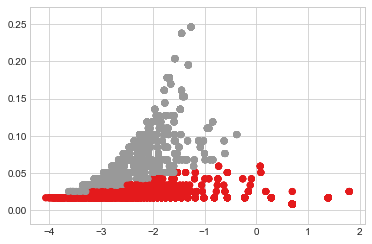

In [37]:
unique_counts['log_lps'] = np.log(unique_counts['lps'])

EXP = 1.5
INTERCEPT = -5.8

def f(x, y):
    return np.array(np.power(EXP, x+INTERCEPT) < y).astype(np.int)

unique_counts['like'] = f(unique_counts['log_lps'], unique_counts['lpd'])

plt.scatter(y=unique_counts['lpd'], x=unique_counts['log_lps'], c=unique_counts['like'], cmap='Set1')

In [ ]:
unique_labeled = unique_counts.drop(['lpd', 'lps'], axis=1).drop_duplicates('id')
unique_labeled = get_unique().merge(unique_labeled, on='id')

## Do I prefer to discover new music or discover new songs?

Do I have any go-to songs? artists? A go-to song is a song...

Do I have any hidden favorite songs? artists? A hidden favorite is a song or artist that reappears infrequently: has at least two weeks between each listen, but no more than eight weeks between each listen.

In [ ]:
hidden_fav_songs = []

for i, row_outer in full_history.iterrows():
    
    if row_outer['id'] in hidden_fav_songs:
        continue
    
    matches = full_history.loc[full_history['id'] == row_outer['id']]
    
    n = len(matches['timestamp'])
    ts = np.array(matches['timestamp'].sort_values())
    
    if n / day_range > 0.025 and n / day_range < 0.1:
        #print((row_outer['name'], n))
        add = True
        for i in range(n-1):
            delta = int((ts[i+1] - ts[i]) / 8.64e13)
            if delta != 0 and (delta < 7 or delta > 45):
                add = False
                #print(str(delta) + ' -> fail')
                break
            #print(delta)
                
        if add:
              hidden_fav_songs.append(row_outer['id'])
                
full_history.loc[full_history['id'].isin(hidden_fav_songs), ['name', 'id']].drop_duplicates('id')